In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from cli.cmonitor import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [3]:
toload = [ 
    dict(name="hiresbase", id="d34-d28a_neutbc_fixes", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="dirichlet", id="hn2d1b-dirichlet_hot", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="xpoint", id="xph1-base_master", unnormalise_geom = True, use_xhermes = True, squash = False), 

    dict(name="floorfix_allfields", id="hn2d1c-floorfix_allfields", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="mergemaster", id="hn2d1cb-merge_master", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case d34-d28a_neutbc_fixes
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 11:28:35, dmp file date 12/11/2023, 19:20:57

Unnormalising with xHermes
- Reading case hn2d1c-floorfix_allfields
-----------------------



Unnormalising with xHermes
- Reading case hn2d1cb-merge_master
-----------------------

Unnormalising with xHermes


# Convergence

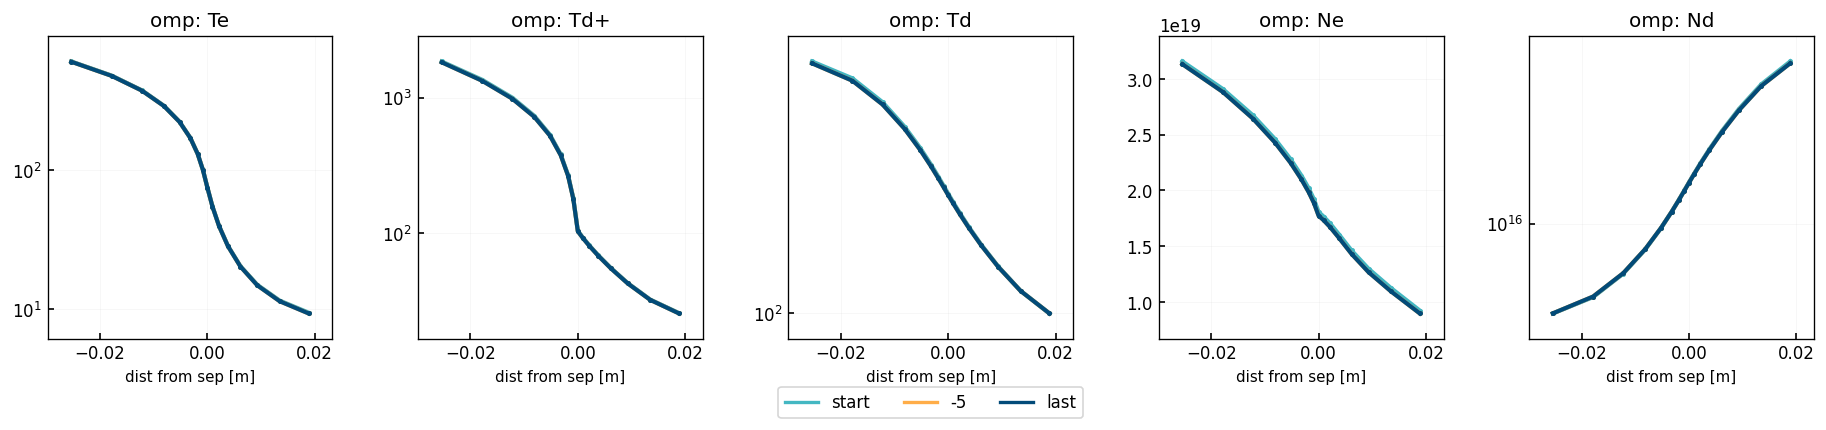

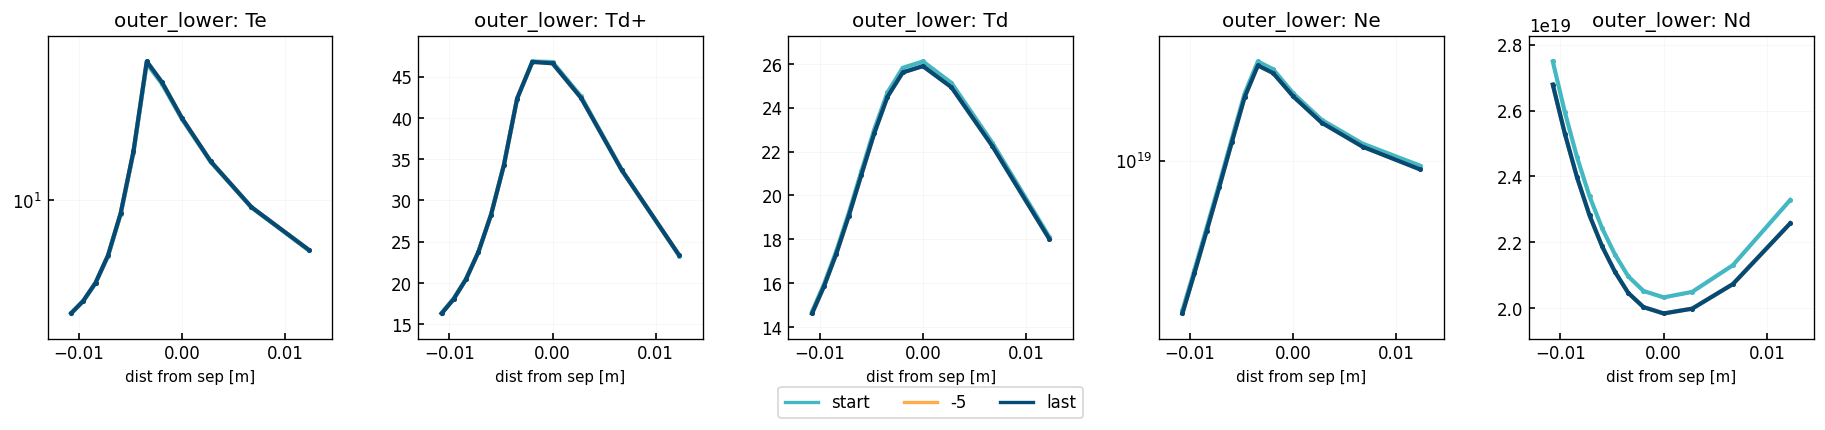

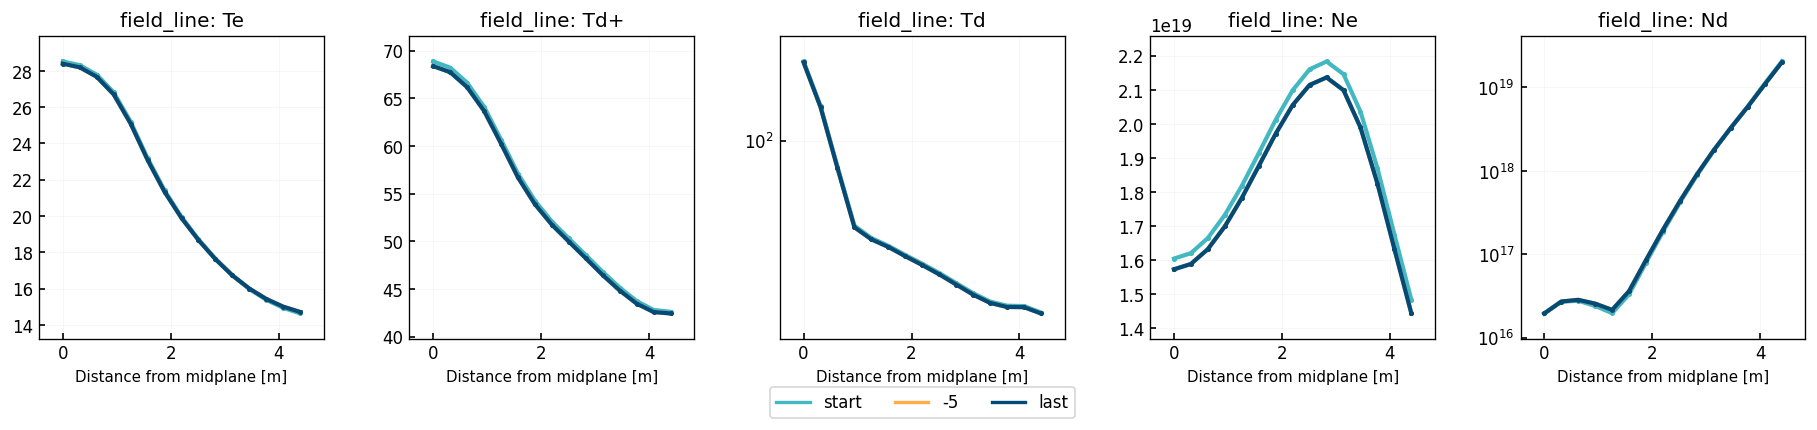

In [4]:
case = "floorfix_allfields"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Compare to base

In [6]:
cs.keys()

dict_keys(['hiresbase', 'dirichlet', 'xpoint', 'floorfix_allfields'])

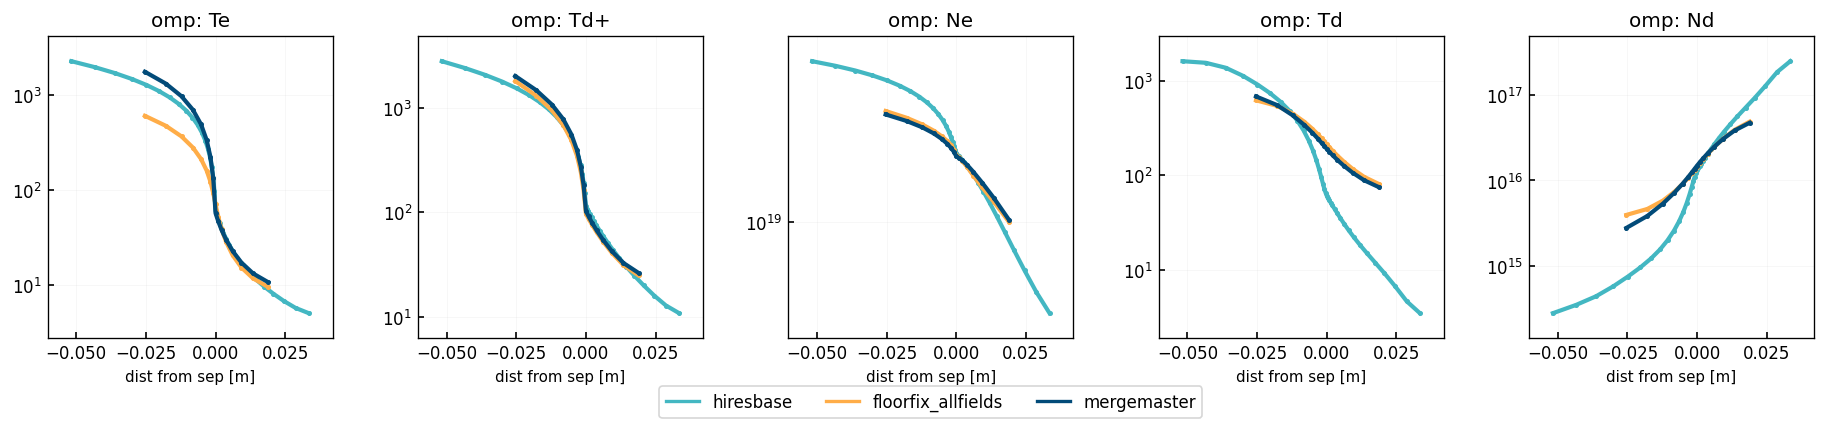

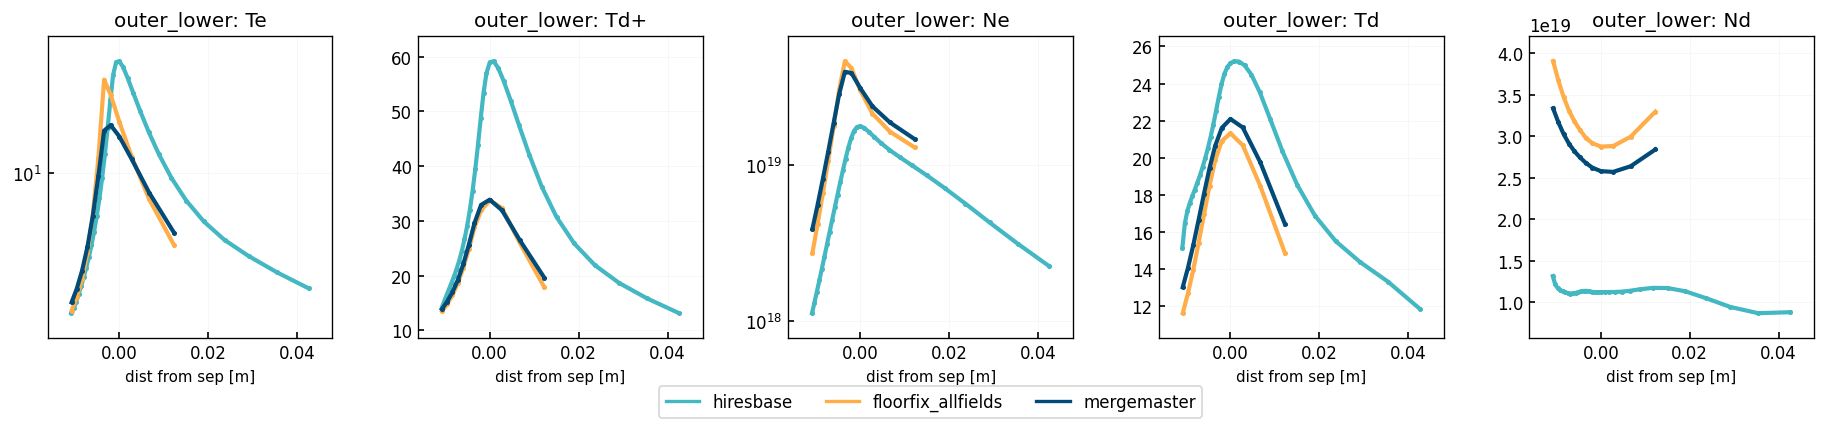

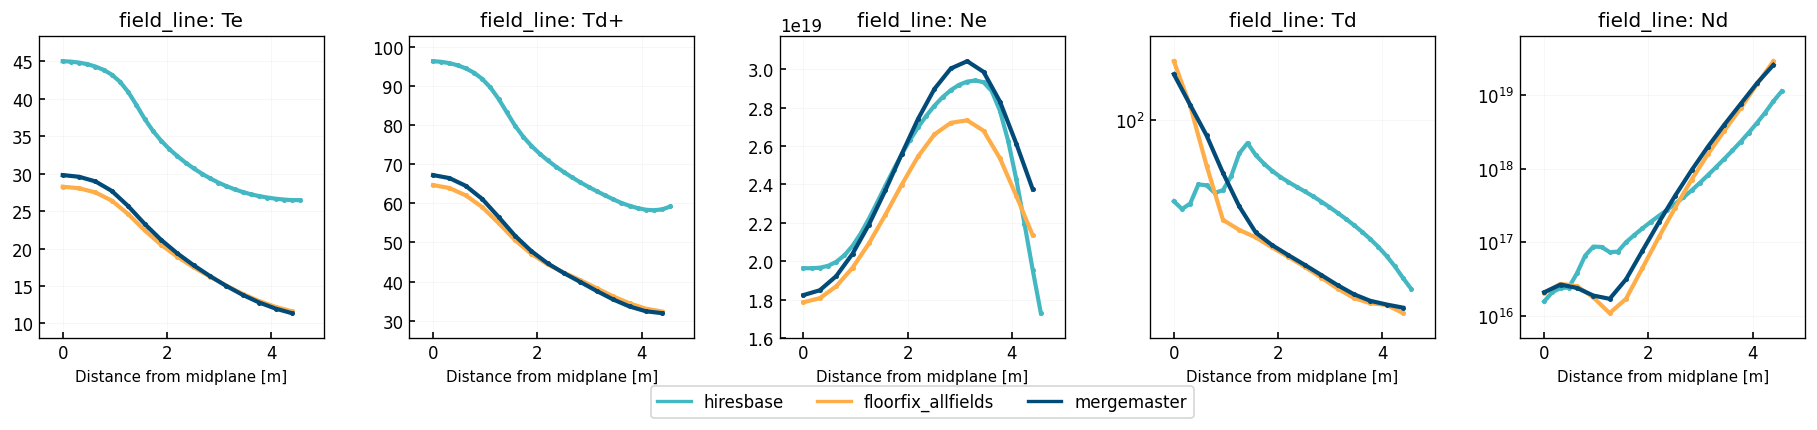

In [4]:
toplot = {}
for case in cs:

    toplot[case] = cs[case].ds.isel(t=-1, x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

In [26]:
for case in cs:
    ds = cs[case].ds.isel(t=-1)
    # if "sd+_src" in ds.data_vars:
    hfi = (ds["Pd+_src"] * ds["dv"] * 1e-6 * 3/2).sum().values
    if "Sd_src" in ds.data_vars:
        pf = (ds["Sd_src"] * ds["dv"]).sum().values
    else:
        pf = 0

    
    print(f"{case} : {pf:.3e}")

hiresbase : 1.210e+21
dirichlet : 1.200e+21
xpoint : 1.200e+21
floorfix_allfields : 1.200e+21


In [19]:
[print(x) for x in ds.data_vars if "src" in x]

Pd+_src
Pd_src
Pe_src
Sd+_src
Sd_src


[None, None, None, None, None]

## State of Td

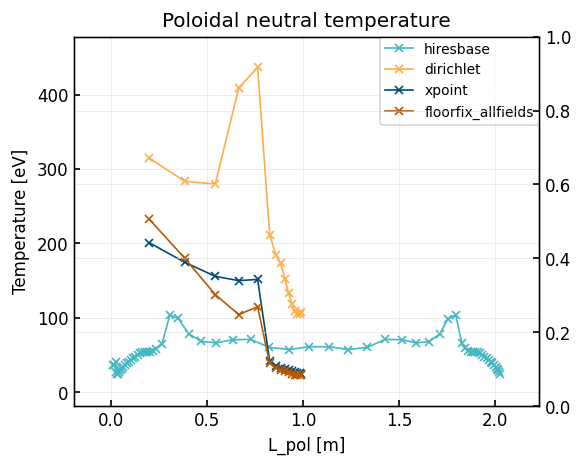

In [5]:

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

cases = cs.keys()

ax2 = ax.twinx()

# colors = ["teal", "darkorange", "firebrick"]

for i, case in enumerate(cases):
    ds = cs[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        marker = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        marker = "+"
    else:
        marker = "x"
    ax.plot(dist, fl["Td"], label = case, marker = marker, ms = 5, lw = 1, 
            # color = colors[i]
            )
    
    # try:
    # try:
    #     ax2.plot(dist, fl["Sd+_rec"], label = case, marker = marker, ms = 5, lw = 1)
    # except:
    #     pass
                # color = colors[i])
# ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
# ax.set_ylim(0,200)

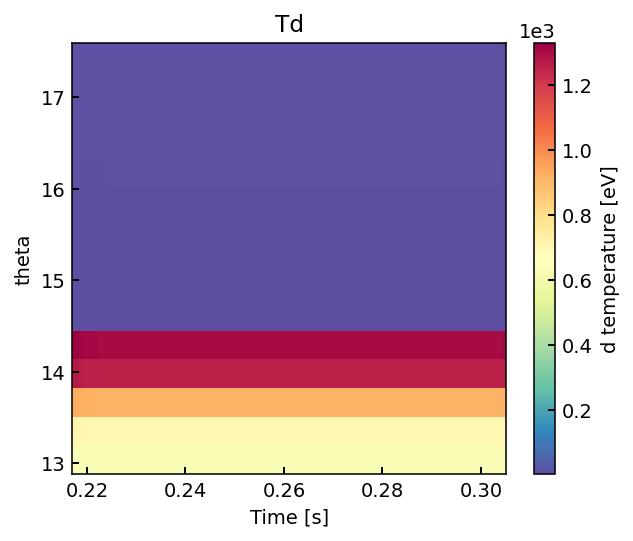

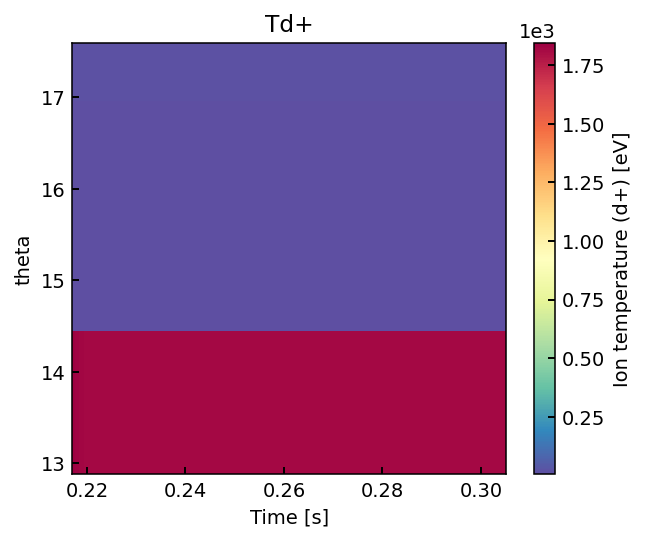

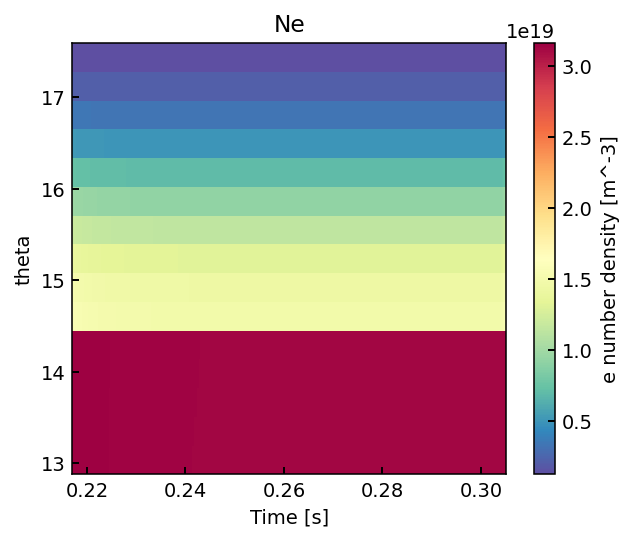

In [7]:
cs.keys()

ds = cs["floorfix_allfields"].ds
m = ds.metadata
fl = ds.isel(x = 2, theta = slice(41,-2))

for param in ["Td", "Td+", "Ne"]:
    fl[param].plot(cmap = "Spectral_r", linewidth = 0.0, color = "k", x = "t")
    plt.grid(False)
    plt.title(param)
    plt.show()

# Detailed analysis

## OMP - profiles

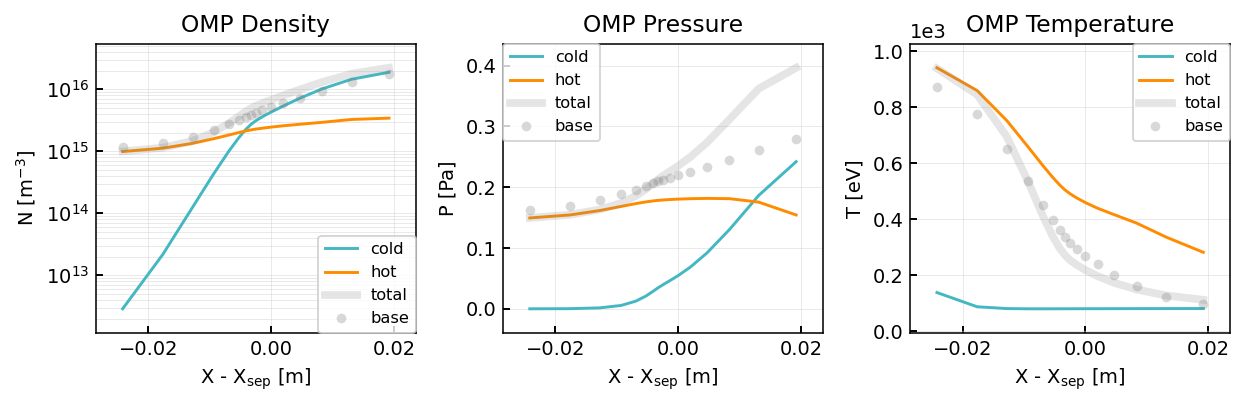

In [6]:
ds = cs["hnthresh20"].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2))
reg2 = cs["base"].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2), t = -1)
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("OMP Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("OMP Pressure")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("OMP Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - transport

In [8]:
for case in cs:
    cs[case].ds = calculate_radial_fluxes(cs[case].ds)

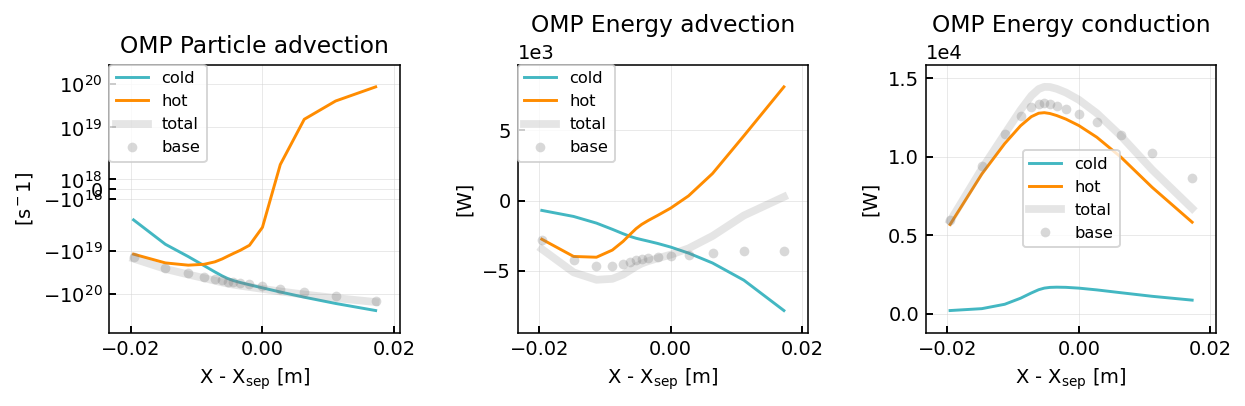

In [10]:
ds = cs["main"].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2))
reg2 = cs["base"].ds.hermesm.select_region("outer_midplane_a").isel(x = slice(3,-2), t = -1)
title = "OMP"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("OMP Particle advection")
ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["pf_perp_diff_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["pf_perp_diff_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["pf_perp_diff_L_d"]+reg["pf_perp_diff_L_d*"], label = "total", **totkwargs)
ax.plot(x, reg2["pf_perp_diff_L_d"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("OMP Energy advection")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_conv_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["hf_perp_conv_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["hf_perp_conv_L_d"]+reg["hf_perp_conv_L_d*"], label = "total", **totkwargs)
ax.plot(x, reg2["hf_perp_conv_L_d"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("OMP Energy conduction")
ax.set_ylabel("[W]")
ax.plot(x, reg["hf_perp_diff_L_d"], label = "cold", **kwargs)
ax.plot(x, reg["hf_perp_diff_L_d*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["hf_perp_diff_L_d"]+reg["hf_perp_diff_L_d*"]), label = "total", **totkwargs)
ax.plot(x, reg2["hf_perp_diff_L_d"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


## OMP - sources

Text(0.5, 0, 'X - $X_{sep}$ [m]')

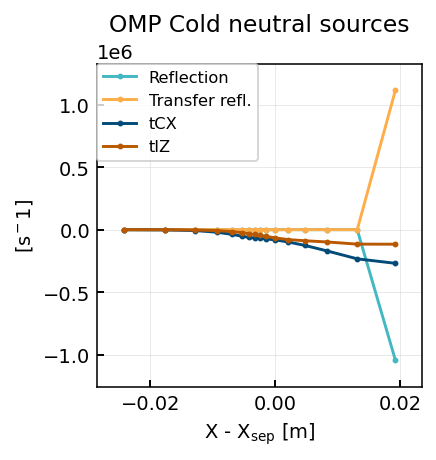

In [11]:
ds = cs["hnthresh20"].ds.isel(t=-1)
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2)).squeeze()

fig, ax = plt.subplots(1, figsize = (3,3))

x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 2)

ax.set_title("OMP Cold neutral sources")
# ax.set_yscale("symlog", linthresh = 5e18)
ax.set_ylabel("[$s^-1$]")
ax.plot(x, reg["Ed_wall_refl"], label = "Reflection", **kwargs)
ax.plot(x, reg["Edd*_wall_refl"], label = "Transfer refl.", **kwargs)
# ax.plot(x, reg["Edd+_cx"], label = "CX", **kwargs)
ax.plot(x, reg["Edd+_cxt"], label = "tCX", **kwargs)
ax.plot(x, reg["Edd+_iz"]*-1, label = "tIZ", **kwargs)

ax.legend(fontsize = "small")
ax.set_xlabel("X - $X_{sep}$ [m]")



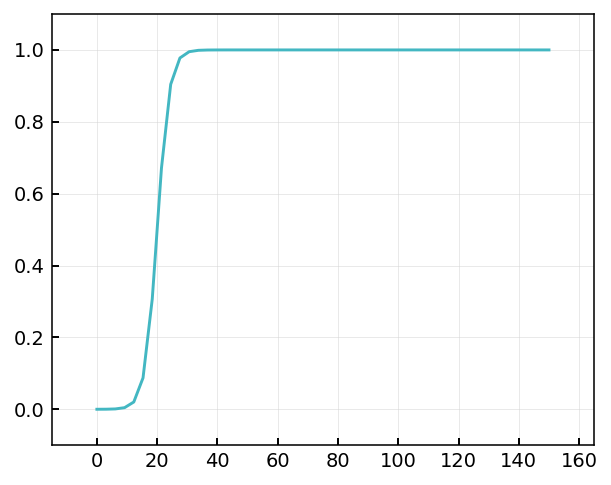

In [128]:
x = np.linspace(0,150)

y = 1 / (1 + np.exp(-0.5*(x - 20)))

fig, ax = plt.subplots()
ax.plot(x,y)

## FIeld line

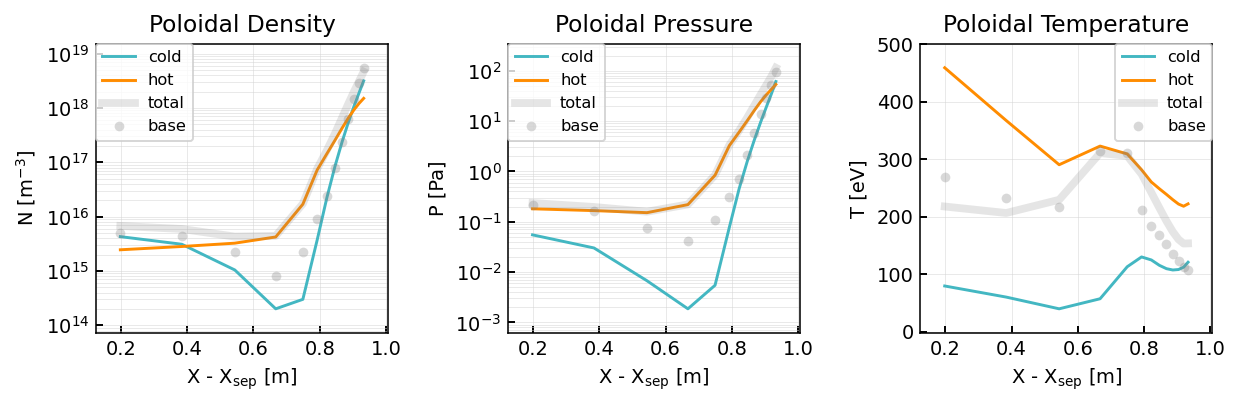

In [12]:
ds = cs["hnthresh20"].ds
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
reg2 = cs["base"].ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").isel(theta = slice(None,-2), t = -1).squeeze()
title = "Field line"

fig, axes = plt.subplots(1,3, figsize = (9,3))

x = np.cumsum(reg["dl"]).values

kwargs = dict(marker = "o", ms = 0)
totkwargs = dict(c = "grey", lw = 4, alpha = 0.2)
basekwargs = dict(c = "grey", lw = 0, marker = "o", ms = 5, alpha = 0.3, markeredgewidth = 0)

ax = axes[0]
ax.set_title("Poloidal Density")
ax.set_yscale("log")
ax.set_ylabel("N [$m^{-3}$]")
ax.plot(x, reg["Nd"], label = "cold", **kwargs)
ax.plot(x, reg["Nd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Nd"]+reg["Nd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Nd"], label = "base", **basekwargs)

ax = axes[1]
ax.set_title("Poloidal Pressure")
ax.set_yscale("log")
ax.set_ylabel("P [Pa]")
ax.plot(x, reg["Pd"], label = "cold", **kwargs)
ax.plot(x, reg["Pd*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, reg["Pd"]+reg["Pd*"], label = "total", **totkwargs)
ax.plot(x, reg2["Pd"], label = "base", **basekwargs)

ax = axes[2]
ax.set_title("Poloidal Temperature")
ax.set_ylabel("T [eV]")
ax.plot(x, reg["Td"], label = "cold", **kwargs)
ax.plot(x, reg["Td*"], label = "hot", c = "darkorange", **kwargs)
ax.plot(x, (reg["Pd"]+reg["Pd*"])/(reg["Nd*"]+reg["Nd"])/constants("q_e"), label = "total", **totkwargs)
ax.plot(x, reg2["Td"], label = "base", **basekwargs)


for ax in axes:
    ax.legend(fontsize = "small")
    ax.set_xlabel("X - $X_{sep}$ [m]")

    ax.set_xscale("linear")
    
fig.tight_layout()


# 2D plots

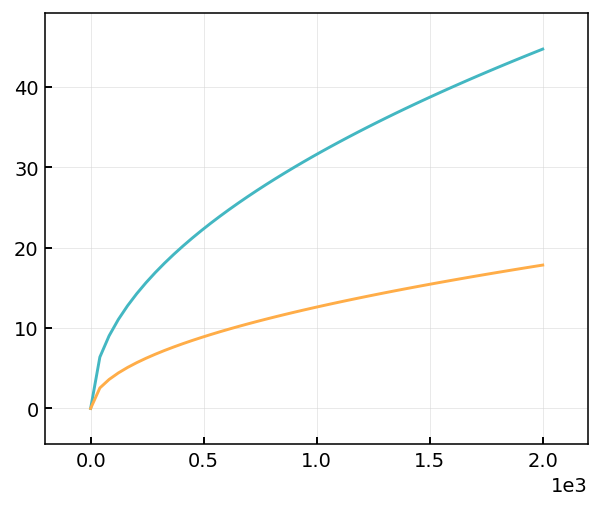

In [6]:
T = np.linspace(0,2000)
y1 = np.sqrt(T)
y2 = 0.25 * np.sqrt(8 * T/ np.pi)

fig, ax = plt.subplots()
ax.plot(T, y1)
ax.plot(T, y2)

## Hot neutral diags

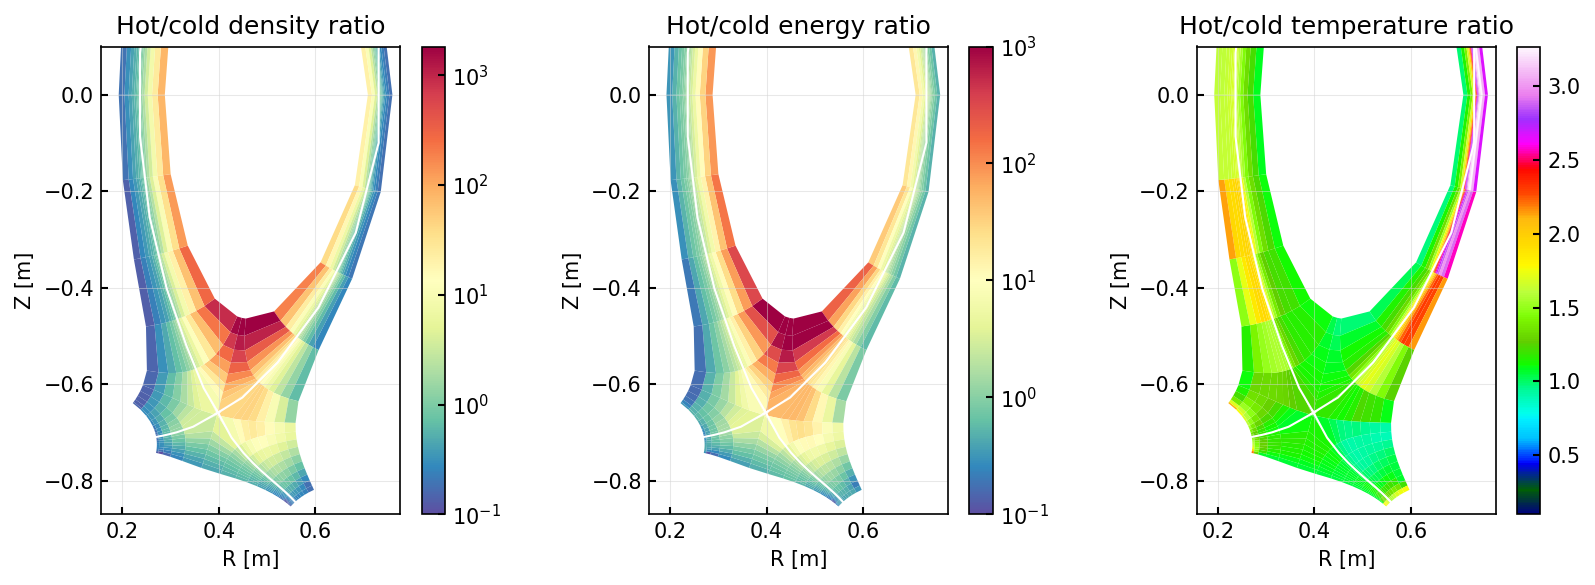

In [13]:
fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

ds = cs["main"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
(ds["Nd*"] / ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = None, logscale = True, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["Pd*"] / ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
                                                           vmin = 0.1, vmax = 1000, logscale = True, 
                                                           separatrix_kwargs = sepkwargs, targets = False)

(ds["Td*"] / ds["Td"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", antialias = True, 
                                                            vmin = 0.1, vmax = None, logscale = False, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

axes[0].set_title("Hot/cold density ratio")
axes[1].set_title("Hot/cold energy ratio")
axes[2].set_title("Hot/cold temperature ratio")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()

## Fields

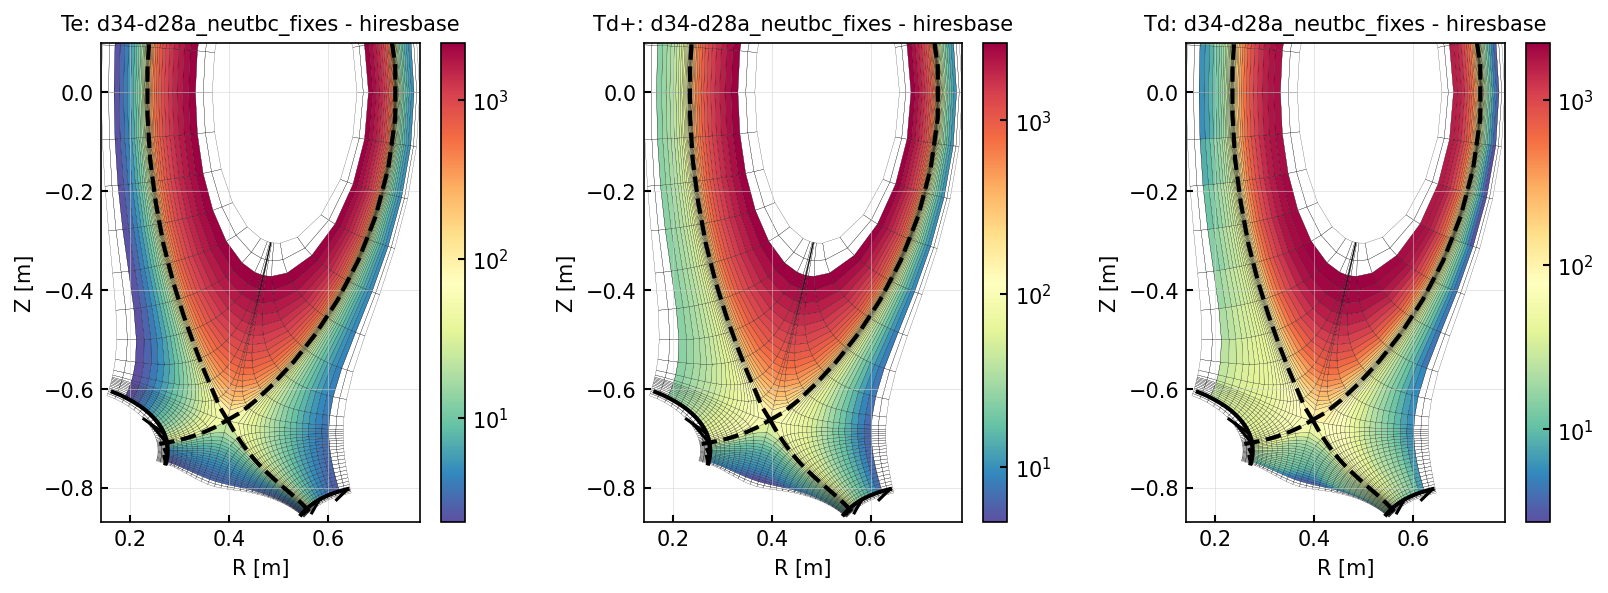

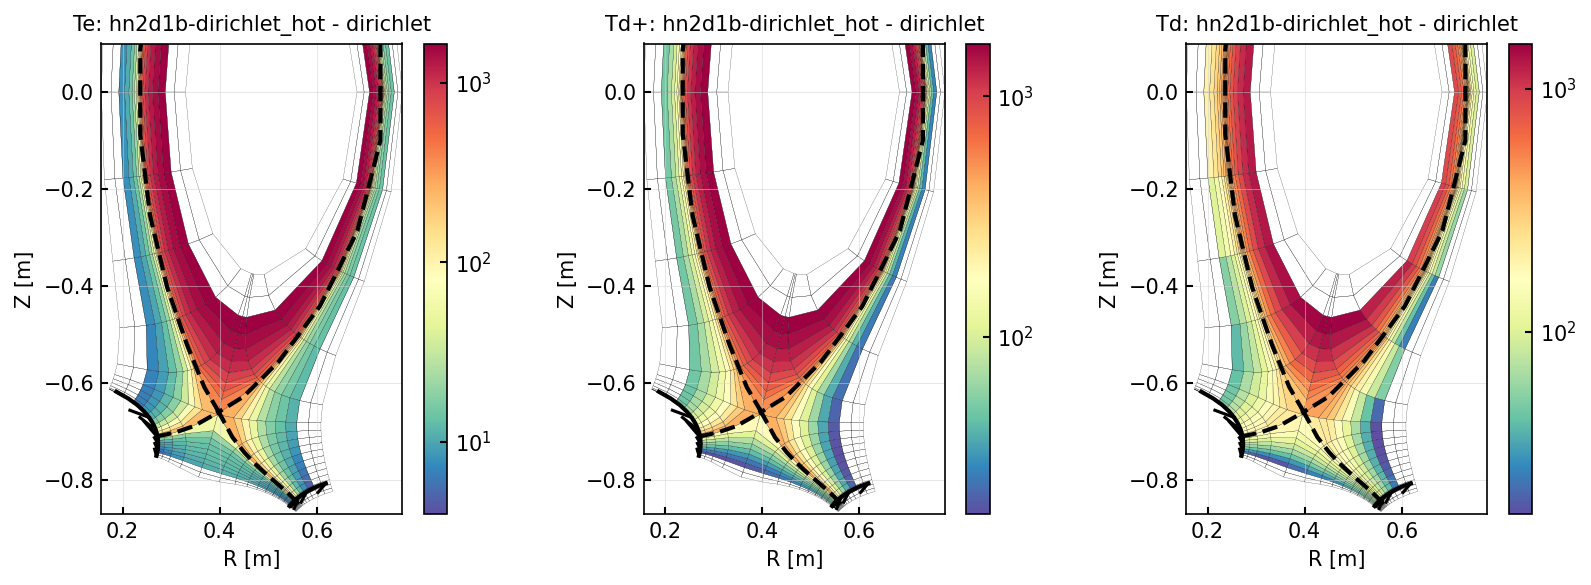

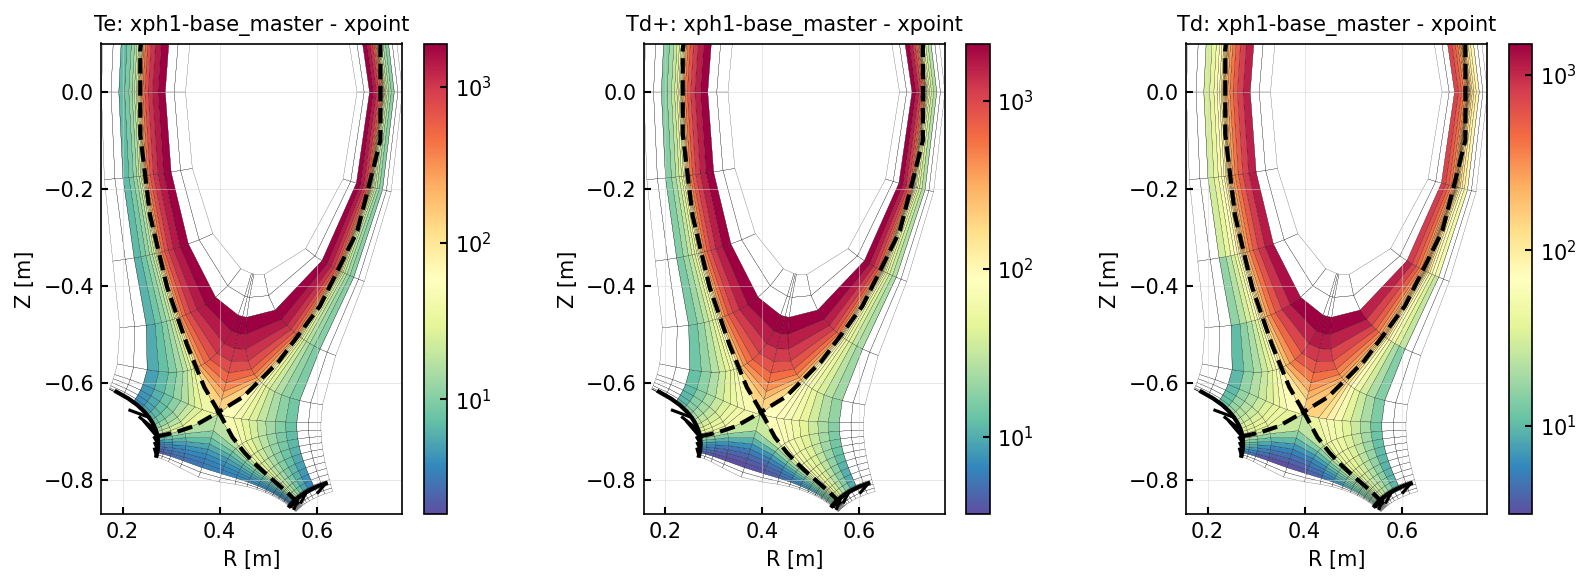

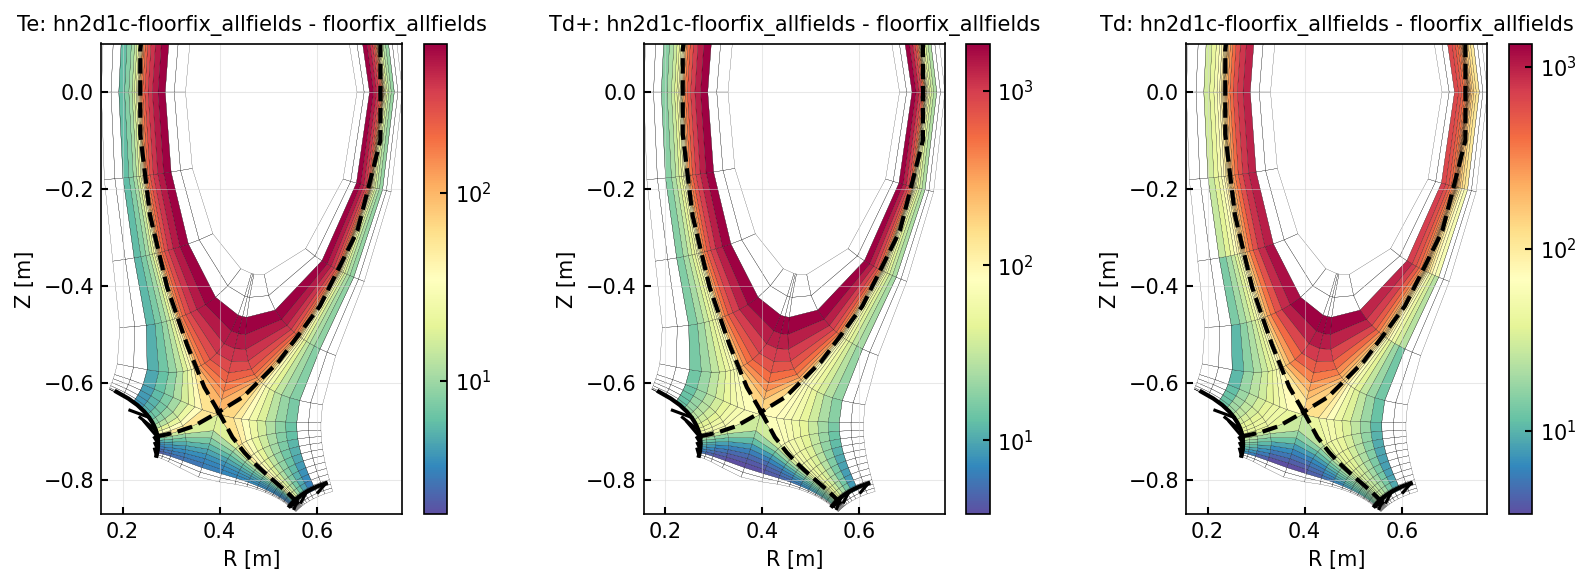

In [5]:
clean_guards = True

xlims = (None, None)
ylims = (-0.87,0.1)

params = ["Te", "Td+", "Td"]
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,3, figsize = (11,4), dpi = 150)
    newds = cs[case].ds.isel(t=-1)
    
    ax = axes[0]
    param = params[0]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[1]
    param = params[1]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[2]
    param = params[2]
    data = (newds[param])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True, separatrix_kwargs = sepkwargs)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(f"{param}: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    fig.tight_layout()


# Floor check

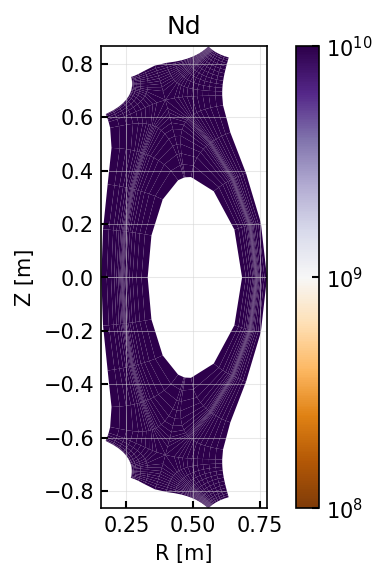

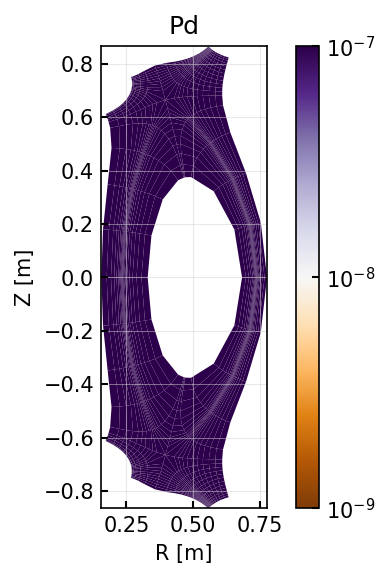

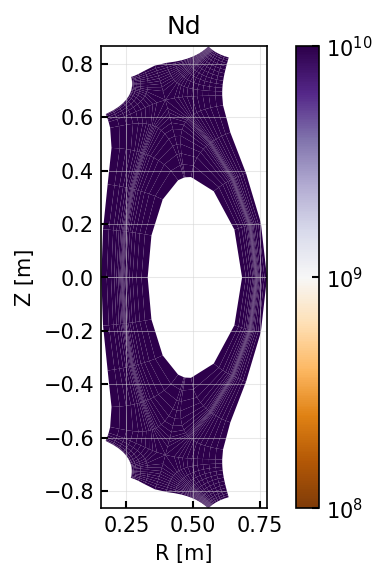

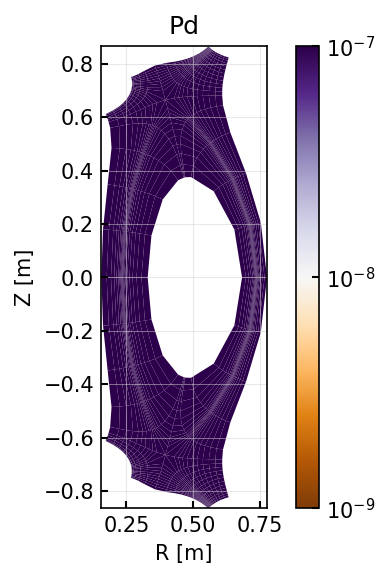

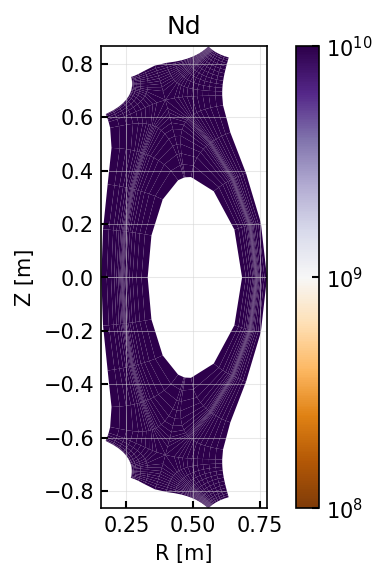

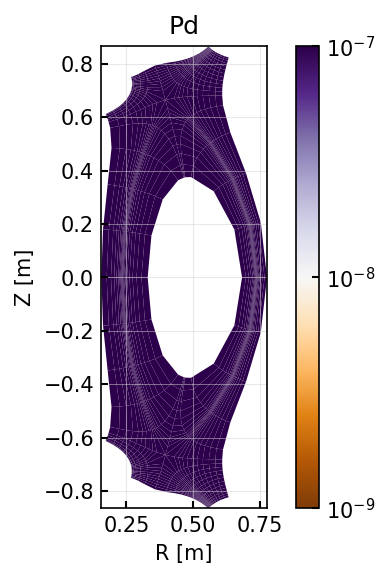

In [5]:
# ds = cs["newalldisabled_lopnfloor"].ds.isel(t=-1)
for case in cs:
    ds = cs[case].ds.isel(t=-1)
    # cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["darkorange", "white", "navy"], N=3)
    cmap = "PuOr"

    floors = ds.hermesm.get_floors()
    nn_floor_si = floors["nn_floor_si"]
    pn_floor_si = floors["pn_floor_si"]

    fig, ax = plt.subplots(dpi = 150)
    (ds["Nd"]).bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
                                                        antialias = True,
                                                        logscale = True,
                                                        vmin = nn_floor_si*1e-1,
                                                        vmax = nn_floor_si*1e1)
    # ax.set_ylim(-0.9, 0)

    fig, ax = plt.subplots(dpi = 150)
    data = ds["Pd"]/ds["Pd"].attrs["conversion"]
    data.bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
                                                        antialias = True,
                                                        logscale = True,
                                                        vmin = floors["pn_floor"]*1e-1,
                                                        vmax = floors["pn_floor"]*1e1)
    # ax.set_ylim(-0.9, 0)